<h1 align='center'>K-Means clustering (Phân cụm K-Means)</h1>

# 1. Giới thiệu về K-Means clustering
Phân cụm là kỹ thuật rất quan trọng trong khai phá dữ liệu, nó thuộc lớp các phương pháp Unsupervised Learning trong Machine Learning. Nó được định nghĩa là các qui trình tìm cách nhóm các đối tượng đã cho vào các cụm (clusters), sao cho các đối tượng trong cùng 1 cụm tương tự (similar) nhau và các đối tượng khác cụm thì không tương tự (Dissimilar) nhau.

Mục đích của phân cụm là tìm ra bản chất bên trong các nhóm của dữ liệu. Các thuật toán phân cụm (Clustering Algorithms) đều sinh ra các cụm (clusters). Tuy nhiên, không có tiêu chí nào là được xem là tốt nhất để đánh hiệu của của phân tích phân cụm, điều này phụ thuộc vào mục đích của phân cụm như: data reduction, “natural clusters”, “useful” clusters, outlier detection

**Kỹ thuật phân cụm có thể áp dụng trong rất nhiều lĩnh vực như:**
* Thông tin nhân khẩu học: đánh giá giới tính, tuổi tác, tình trạng hôn nhân, nghề nghiệp:
* Thông tin về mặt địa lý: đánh giá thông tin tại các địa phương, phục vụ cho các doanh nghiệp mở của hoạt động trao đổi tại địa điểm đó.
* Tâm lý học: đánh giá tầng lớp xã hội, thói quen chi tiêu, mức độ tiêu thụ sản phẩm/dịch vụ, mong muốn và lợi ích.

**Mục đích phân cụm khách hàng trong lĩnh vực kinh doanh:**<br>
Thị trường cạnh tranh, đời sống cải thiện, sản phẩm/dịch vụ phát triển đa dạng, điều này tạo ra những sự khác biệt trong nhu cầu của mỗi người. Chính vì thế cần hướng đến phân loại ra các nhóm khách hàng, doanh nghiệp sẽ dễ dàng trong khâu quản lý khách hàng nhằm thỏa mãn được sự hài lòng của khách hàng. <br>

Phân loại khách hàng chính là nắm bắt những đặc điểm chung trong dữ liệu khách hàng, thống kê những đặc tính tương đồng của những khách hàng trước và sau khi mua/sử dụng dịch vụ/sản phẩm của doanh nghiệp từ đó chia các đối tượng khách hàng thành những nhóm nhỏ. Từ đó doanh nghiệp có thể tạo ra chiến lược tiếp thị phù hợp cho từng phân khúc.<br>

# Import libraries

In [2]:
import pandas as pd

import numpy as np
from numpy import random

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (18, 8)

import seaborn as sns
plt.style.use('fivethirtyeight')

# Suppress plt and seaborn warning
import warnings
warnings.filterwarnings('ignore')


### 1.1.1 Về bộ dữ liệu được cung cấp:
Mua sắm cá nhân còn gọi là đi chợ (siêu thị,...) hay mua đồ là các hoạt động lựa chọn và mua hàng hóa trực tiếp tại các điểm bán lẻ, đây không chỉ là một hoạt động mua bán đơn thuần mà còn là hoạt động giải trí. Mua sắm thường được thực hiện ở các địa điểm cố định (tại các cửa hàng, các cửa hàng bách hóa, tiệm tạp hóa hoặc chợ, siêu thị...), các mặt hàng mua sắm thường là những mặt hàng gia dụng, thẩm mỹ,...vv

Bộ dữ liệu dưới đây là thông tin mua sắm của 200 khách hàng tại một siêu thị được cung cấp thông qua thẻ khách hàng thân thiết. Bộ dữ liệu này cung cấp cho ta 5 trường dữ liệu sau: 
* Customer ID: Mã khách hàng - trường này có thể drop vì nó không hữu ích trong việc huấn luyện.
* Gender: Giới tính khách hàng (Nam/ nữ) - không có giới tính khác.
* Age: Độ tuổi của khách hàng (tập trung từ 18-70 tuổi)
* Annual Income: Thu nhập của khách hàng (trong khoảng 13-137) cơ bản là không có outlier
* Spending Score: Điểm chi tiêu của khách hàng (từ 1-99)

# Load dataset

In [3]:
dataset = pd.read_csv('./Dataset/Mall_Customers.csv')
dataset.head(5)

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


### 1.1.2 Đánh giá sơ bộ về dataset được cung cấp:

1. Bộ dữ liệu cung cấp đươc chiếm đa số bởi nữ giới: (nam giới chỉ chiểm 44%)
2. Độ tuổi từ 18-70 và trung bình rơi vào 39 tuổi
3. Điểm chi tiêu từ 1-99 trung bình rơi vào 50.2 điểm
4. Thu nhập trung bình là 60k$ một năm

In [4]:
dataset.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [5]:
# mô tả data
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [6]:
# kiểm tra missing data
dataset.isnull().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

-> Tổng quan thì dữ liệu này khá là đẹp, đẹp như một bức tranh

### 1.1.3 Visualizations dánh giá mỗi quan hệ giữa các thông số **Giới tính**, **Thu nhập trung bình** và **Điểm chi tiêu**

<b> Phân bố điểm chi tiêu và thu nhập của từng khách hàng theo tuổi và giới tính </b>

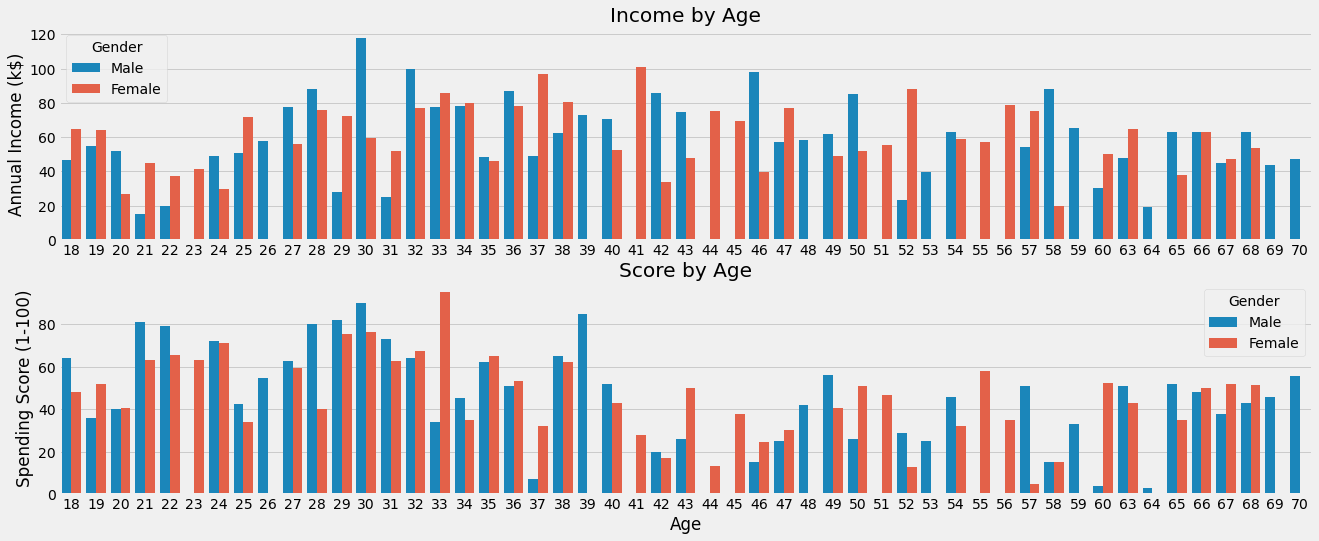

In [8]:
plt.figure(figsize=(20,8))
plt.subplot(2,1,1)
sns.barplot(x=dataset['Age'], y=dataset['Annual Income (k$)'], hue=dataset['Gender'], ci=0)
plt.title('Income by Age')
plt.xlabel('')

plt.subplot(2,1,2)
sns.barplot(x=dataset['Age'], y=dataset['Spending Score (1-100)'], hue=dataset['Gender'], ci=0)
plt.title('Score by Age')

plt.show()

**Đánh giá thu nhận và chi tiêu theo độ tuổi:** <br>
* Từ 18 – 24 tuổi: Sinh viên hoặc mới tốt nghiệp ra trường, có thu nhập còn thấp còn phụ thuộc vào gia đình. Mua hàng như một phương thức để giải trí.

* Từ 25 – 30 tuổi: Đa phần họ ổn định cuộc sống, có thu nhập cao hơn, có nhu cầu đối với những sản phẩm chất lượng cao, mua sắm sản phẩm cho mẹ và bé đối với nữ đã lập gia đình. Nhưng dường như về mặt chi tiêu trong gia đình nam giới cao hơn do mới yêu, quỹ tích lũy vẫn còn.

* Từ 31 – 40 tuổi: Nhóm có thu nhập cao, có khoản tiết kiệm dư dả nên yêu cầu mua sắm khắt khe hơn như mong muốn sản phẩm chất lượng cao, hàng cao cấp và không bận tâm nhiều về giá cả. Tập trung vào lợi ích của món hàng đem lại. Và khi này họ đã lập gia đình nên có vẻ phụ nữ là người chi tiêu nhiều hơn trong việc mua sắm.

* Từ 41 – 50 tuổi: Nhóm có tài sản riêng, có nhu cầu mua sắm nhiều hơn cho con cái, như cầu thấp hơn so vơi ba nhóm ở trên.

* Trên 50 tuổi: Nhóm có khoản tiết kiệm, tài sản riêng hay có con cái đã trưởng thành. Đa phần chi tiêu nhiều cho vấn đề chăm sóc sức khỏe hay như một cách để giải trí cho bản thân ở tuổi trung niên.


**Phân bố mật độ và độ chênh lệch tuổi, thu nhập và điểm chi tiêu dựa trên giới tính:**

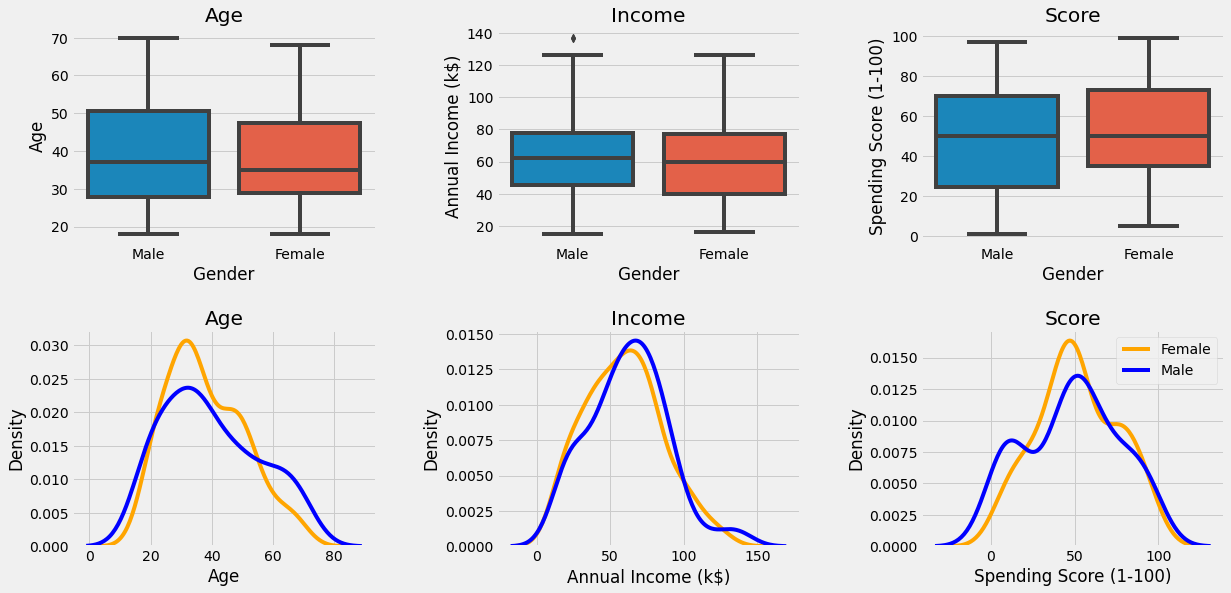

In [10]:
plt.figure(figsize=(20,9))
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)

plt.subplot(2,3,1)
sns.boxplot(x=dataset['Gender'], y=dataset['Age'])
plt.title('Age')

plt.subplot(2,3,2)
sns.boxplot(x=dataset['Gender'], y=dataset['Annual Income (k$)'])
plt.title('Income')

plt.subplot(2,3,3)
sns.boxplot(x=dataset['Gender'], y=dataset['Spending Score (1-100)'])
plt.title('Score')

plt.subplot(2,3,4)
sns.distplot(dataset['Age'][dataset['Gender']=='Female'], color='orange', hist=False, kde=True, label='Female')
sns.distplot(dataset['Age'][dataset['Gender']=='Male'], color='blue', hist=False, kde=True, label='Male')
plt.title('Age')

plt.subplot(2,3,5)
sns.distplot(dataset['Annual Income (k$)'][dataset['Gender']=='Female'], color='orange', hist=False, kde=True, label='Female')
sns.distplot(dataset['Annual Income (k$)'][dataset['Gender']=='Male'], color='blue', hist=False, kde=True, label='Male')
plt.title('Income')

plt.subplot(2,3,6)
sns.distplot(dataset['Spending Score (1-100)'][dataset['Gender']=='Female'], color='orange', hist=False, kde=True, label='Female')
sns.distplot(dataset['Spending Score (1-100)'][dataset['Gender']=='Male'], color='blue', hist=False, kde=True, label='Male')
plt.legend()
plt.title('Score')

plt.show()

**Đánh giá chung:**

Về dữ liệu:
- Khách hàng Nam giới có độ tuổi trung bình cao hơn nữ giới.
- Thu nhập nam giới ở khoảng trung bình thì bằng với nữ giới nhưng lại có nhiều người có thu nhập ở mức cao.
- Phụ nữ là nhóm thường hay đi shopping hơn so với đàn ông

Theo khả năng kinh tế:
- Tài chính phụ thuộc (18-24 tuổi): Đây là cấp độ có sự phụ thuộc tài chính vào gia đình, họ hàng.
- Tài chính độc lập (25-35 tuổi): Là nhóm có việc làm ổn định, có khoản tiết kiệm riêng hay tài sản riêng, không còn phụ thuộc tài chính vào bất cứ ai. Họ có nhu cầu mua sắm cao để thỏa mãn nhu cầu cá nhân của bản thân và phục vụ gia đình.
- Tự do tài chính (40+ tuổi): Là nhóm có thu cao, họ giàu có và không ngại chi trả một khoản tiền lớn để sở hữu những sản phẩm xa xỉ, dịch vụ chất lượng cao để thể hiện địa vị của bản thân.

# Dendrogram Plot
Biểu đồ thể hiện quan hệ thứ bậc(cluster tree) giữa những đối tượng. Giúp nhìn ra cách tốt nhất để phân bố các đôi tượng vào các cụm.

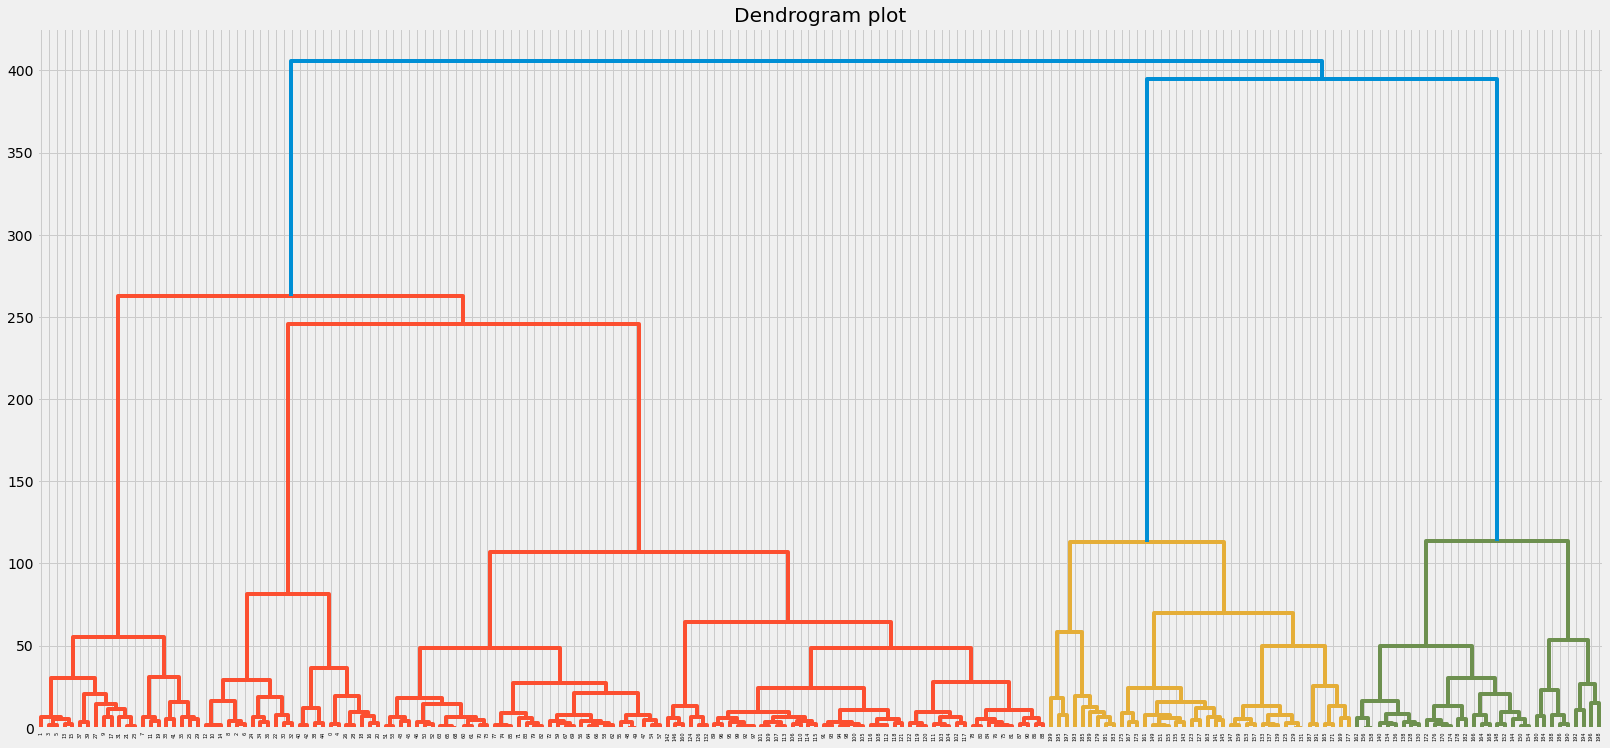

In [85]:
import scipy.cluster.hierarchy as sch
X=dataset.iloc[:, [3, 4]].values
plt.figure(figsize=(25,12))
dendrogram=sch.dendrogram(sch.linkage(X,method = 'ward'))
plt.title('Dendrogram plot')
plt.show()

<p align='center'>Thông qua biểu đồ Dendrogram ta thấy dữ liệu được chia khá là nhiều cụm theo từng điểm dữ liệu. Giả sử nếu ta cắt ở mức 150 thì sẽ được 5 cụm khá rõ dàng</p>

## 1.2 Về phương thức hoạt động của thuật toán K-Means:
1. Chọn ngẫu nhiên K tâm (centroid) cho K cụm (cluster). Mỗi cụm được đại diện bằng các tâm của cụm.
2. Tính khoảng cách giữa các đối tượng (objects) đến K tâm (Ở đây sử dụng khoảng cách Euclidean)
3. Nhóm các đối tượng vào nhóm gần nhất
4. Xác định lại tâm mới cho các nhóm
5. Thực hiện lại bước 2 cho đến khi không có sự thay đổi nhóm nào của các đối tượng

Mô tả lại bưới 2-5 thông qua công thức: </br>
Lặp lại cho tới khi hội tụ: { </br>

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  Với mỗi i: </br>

$$ c^i\text{:=}\arg  \underset{j}{\min }\|x^i-\mu _j\|^2 $$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  Với mỗi j: </br>

$$ \mu _j\text{:=}\frac{\sum _{i=1}^m x^i \left\{c^i=j\right\}}{\sum _{i=1}^m 1 \left\{c^i=j\right\}} $$
}



In [11]:
class KMeans ():
    def __init__(self, X, clusters, seed, iterations=300):
        random.seed(seed)

        self.K = clusters
        self.X = X
        self.iterations = iterations
        self.features = X.shape[1]
        self.data_size = X.shape[0]

    def initRandomCentroids(self, X):
        centroids = np.zeros((self.K, self.features))
        for k in range(self.K):
            centroid = X[np.random.choice(range(self.data_size))]
            centroids[k] = centroid
        return centroids

    def intClusters(self, X, centroids):
        # Will contain a list of the points that are associated with that specific cluster
        clusters = [[] for _ in range(self.K)]

        # Loop through each point and check which is the closest cluster
        for point_idx, point in enumerate(X):
            closest_centroid = np.argmin(
                np.sqrt(np.sum((point - centroids) ** 2, axis=1))
            )
            clusters[closest_centroid].append(point_idx)
        return clusters

    def calculateNewCentroids(self, clusters, X):
        centroids = np.zeros((self.K, self.features))
        for idx, cluster in enumerate(clusters):
            new_centroid = np.mean(X[cluster], axis=0)
            centroids[idx] = new_centroid
        return centroids

    def predictCluster(self, clusters, X):
        y_pred = np.zeros(self.data_size)

        for cluster_idx, cluster in enumerate(clusters):
            for sample_idx in cluster:
                y_pred[sample_idx] = cluster_idx
        return y_pred

    def labledData(self, X, y_pred):
        labeled_data = {}
        X_list = X.tolist()
        for i in range(y_pred.size):
            if y_pred[i] not in labeled_data:
                labeled_data[y_pred[i]] = [X_list[i]]
            else:
                labeled_data[y_pred[i]].append(X_list[i])

        # for key in labeled_data:
        #     np_labled_data = labeled_data[key]
        return labeled_data

    # fit
    def fit(self):
        centroids = self.initRandomCentroids(self.X)

        for it in range(self.iterations):
            clusters = self.intClusters (self.X, centroids)

            previous_centroids = centroids
            centroids = self.calculateNewCentroids(clusters, self.X)

            diff = centroids - previous_centroids

            if not diff.any():
                break

        # Get label predictions
        y_pred = self.predictCluster(clusters, self.X)

        # Get labeled data
        labeled_data = self.labledData(self.X, y_pred)

        wcss=0
        for k in range(self.K):
            wcss+=np.sum((np.array(labeled_data[k])-centroids[k])**2)

        return y_pred, centroids, wcss

# 2. Đánh giá số lượng features để phân cụm bằng Within Cluster Sum Square (WCSS):

## 2.1 Về phương thức Chọn Elbow và WCSS
WCSS là phương pháp đánh giá khoảng cách trung bình của cụm tới trung tâm cụm đó. Để tính ra WCSS trước tiên ta cần tính ra khoảng cách Euclidean giữa từng điểm trong phân cụm tới tâm phân cụm đó. Sau khi tính được khoảng cách tất cả điểm trong phân cụm tới tâm phân cụm đó.

$$ \text{WCSS}=\sum _{i\in n} \left(X_i-y_i\right){}^2 $$

Với:
* $Y_i$: là tâm của  $X_i$
* $X_i$: là các điểm trên tập dữ liệu.

Mục đích chính của việt tính WCSS là để **Tối đa hoá số lượng phân cụm** và **Giói hạn số điểm phân cụm tự phát từ dữ liệu**

## 2.2 Lựa chọn điểm K tối ưu
Within-Cluster Sum of Square (WCSS)

In [12]:
def plotEbow(X, K, seed):
    wcss_array = []
    for k in range(1, K):
        y, centroids, wcss = KMeans(X, k, seed).fit()
        wcss_array = np.append(wcss_array, wcss)

    plt.plot(np.arange(1, K), wcss_array, "-o")
    plt.plot(np.arange(1, K), wcss_array, 'D', markersize=8)

    plt.xlabel('Number of Clusters')
    plt.ylabel('within-cluster sums of squares (WCSS)')
    plt.title('Elbow method to determine optimum number of clusters')
    plt.show()

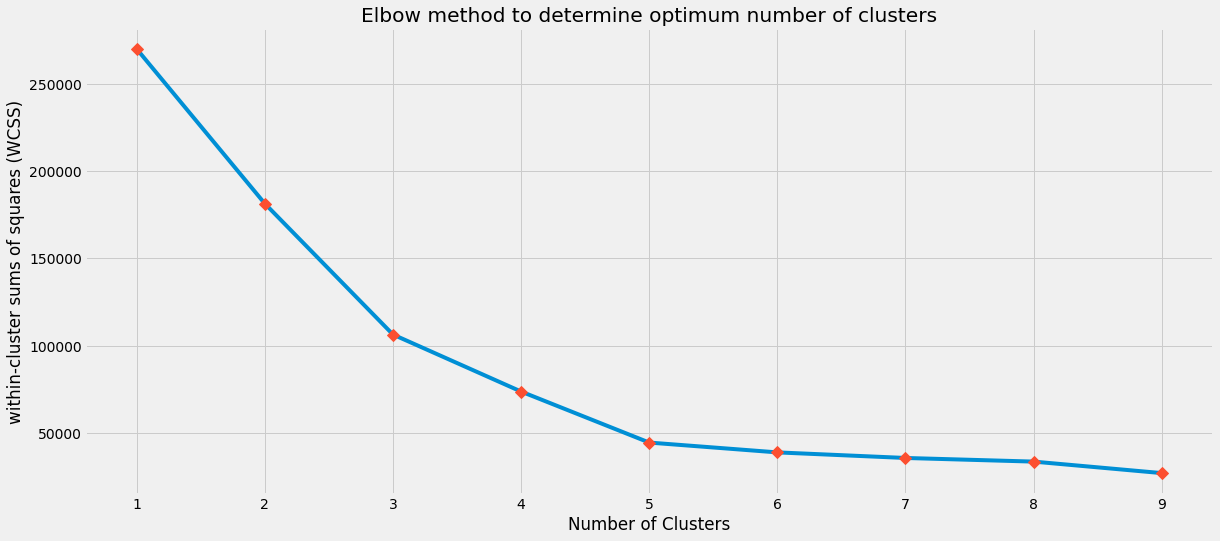

In [14]:
# Choose your seed
seed=69
X = dataset.iloc[:, [3, 4]].values
plotEbow(X, 10, seed)

<p align='center'>Thông qua đánh giá ta thấy điểm K=5 chính là điểm Elbow tối ưu mà ta sẽ lựa chọn để phân cụm bộ dữ liệu.</p>

# 3. Cluster bộ dữ liệu bằng số điểm K tối ưu

In [15]:
# Cluster and add label to dataset
model =  KMeans(X, 5, seed)
Y, centroids, wcss = model.fit()
Y = Y.astype(int)
dataset['Label'] = Y.tolist()

# 4. Sơ đồ hoá kết quả phân cụm và đánh giá thông tin.

Phân loại khách hàng chính là nắm bắt những đặc điểm chung trong dữ liệu khách hàng, thống kê những đặc tính tương đồng của những khách hàng trước và sau khi mua/sử dụng dịch vụ/sảnphẩm của doanh nghiệp từ đó chia các đối tượng khách hàng thành những nhóm nhỏ.

Ý nghĩa của việc phân loại khách hàng
- Định hình được chính xác cần hướng đến bao nhiêu nhóm khách hàng

- Rút ngắn thời gian tìm kiếm thông tin, dữ liệu khách hàng

- Tạo điều kiện cho các dịch vụ tư vấn/chăm sóc khách hàng và đặc biệt là đưa ra các sản phẩm phù hợp cho khách hàng

- Mang lại các chiến lược tiếp cận khách hàng nhanh chóng, đơn giản hiệu quả nhất

Phân loại khách hàng mang lại ý nghĩa vô cùng quan trọng cho doanh nghiệp. Đây cũng là một trong những yếu tố quyết định sự thành công của các kế hoạch Marketing.

## 4.1 Sơ đồ hoá kết quả phân cụm K-Means và đánh giá các phân cụm

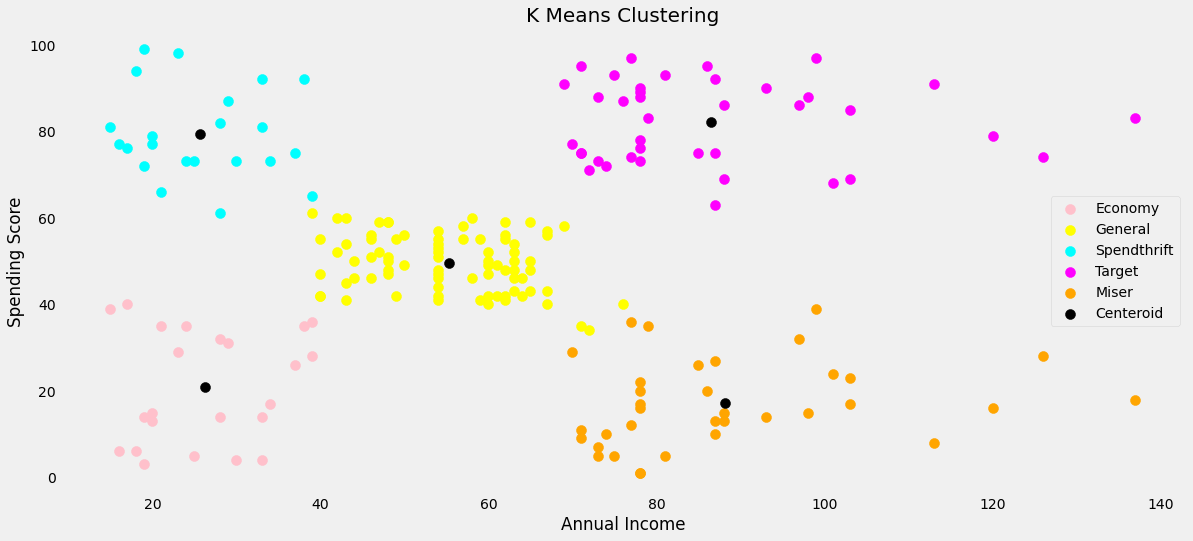

In [16]:
plt.scatter(X[Y == 0, 0], X[Y == 0, 1], s = 100, c = 'pink', label = 'Economy')
plt.scatter(X[Y == 1, 0], X[Y == 1, 1], s = 100, c = 'yellow', label = 'General')
plt.scatter(X[Y == 2, 0], X[Y == 2, 1], s = 100, c = 'cyan', label = 'Spendthrift')
plt.scatter(X[Y == 3, 0], X[Y == 3, 1], s = 100, c = 'magenta', label = 'Target')
plt.scatter(X[Y == 4, 0], X[Y == 4, 1], s = 100, c = 'orange', label = 'Miser')
plt.scatter(centroids[:,0], centroids[:, 1], s = 100, c = 'black' , label = 'Centeroid')

plt.style.use('fivethirtyeight')
plt.title('K Means Clustering', fontsize = 20)
plt.xlabel('Annual Income')
plt.ylabel('Spending Score')
plt.legend()
plt.grid()
plt.show()

<b> Dán nhãn cho từng cụm
 dữ liệu <b> 

In [19]:
dataset['Label'].replace({0: "Economy", 1: "General", 2: "Spendthrift", 3: "Target", 4: "Miser"}, inplace=True)
dataset

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),Label
0,1,Male,19,15,39,Economy
1,2,Male,21,15,81,Spendthrift
2,3,Female,20,16,6,Economy
3,4,Female,23,16,77,Spendthrift
4,5,Female,31,17,40,Economy
...,...,...,...,...,...,...
195,196,Female,35,120,79,Target
196,197,Female,45,126,28,Miser
197,198,Male,32,126,74,Target
198,199,Male,32,137,18,Miser


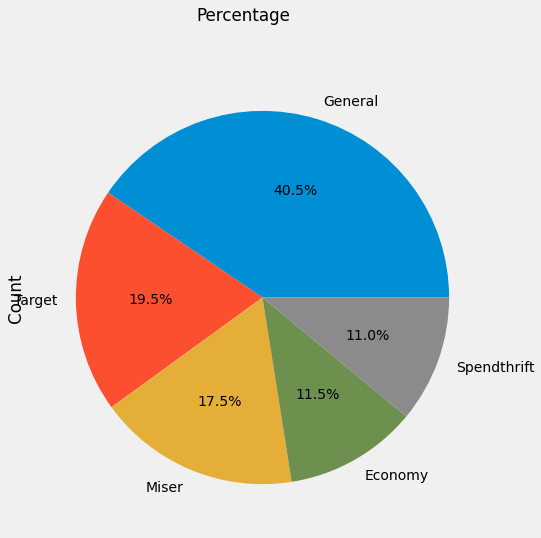

In [20]:
label_df = dataset[['Label']]
label_df_count = label_df.value_counts().reset_index(name='Count')
label_df_count.plot.pie(y='Count', labels=label_df_count['Label'], title="Percentage", subplots=True, autopct='%1.1f%%', legend=False, startangle=0)
plt.show()

Đánh giá phân cụm trên cho ta thấy rõ các nhóm đối tượng khác nhau thông qua số liệu được cung cấp. Có 5 nhóm đối tượng khách hàng là:
1. **General**: 40.5% - Nhóm khách hàng chung
2. **Miser**: 17.5% - Nhiều tiền nhưng chi ít (nhóm đối tượng kẹt xỉ)
3. **Spendthrift**: 11% - Nghèo nhưng chi nhiều (nhóm đối tượng chi tiêu hoang phí)
4. **Economy**: 11.5% - Thu nhập thấp và chi tiêu tiết kiệm (nhóm đối tượng tiết kiệm)
5. **Target**: 19.5% - Nhóm khách hàng nhiều tiền chịu chi (nhóm đối tượng khách hàng cần nhắm tới)

## 4.2 Đánh giá các nhóm khách hàng

### 4.2.1 Đánh giá về giới tính:

Text(0.5, 1.0, 'Gender statistics')

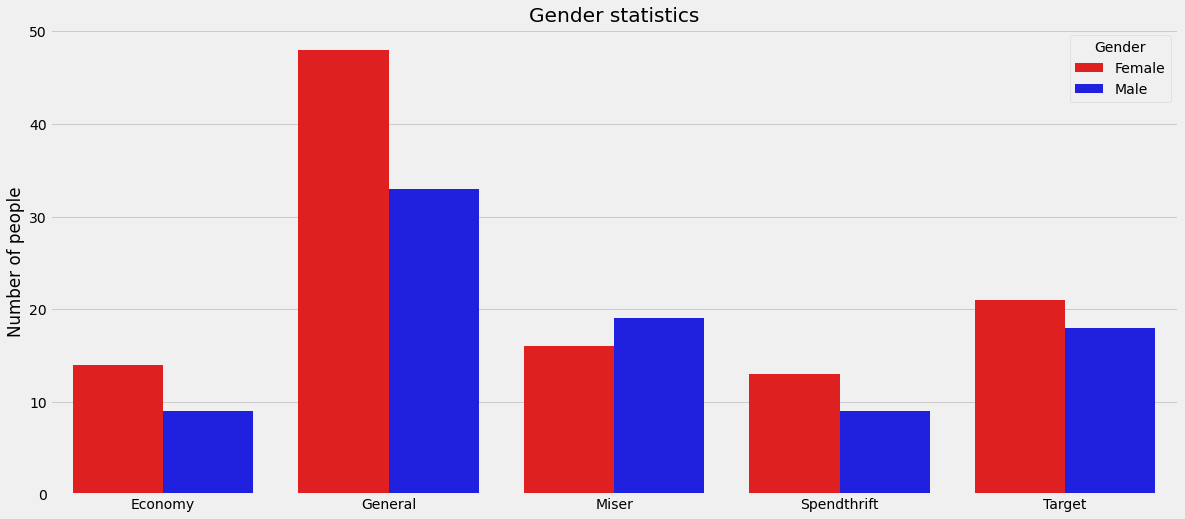

In [21]:
gender_statistics = dataset.groupby(['Gender', 'Label'])['Gender'].size().reset_index(name='Count')
sns.barplot(x="Label", y="Count", hue='Gender', palette={'Female': 'Red', 'Male': 'Blue'}, data=gender_statistics)
plt.xlabel("", size=14)
plt.ylabel('Number of people')
plt.title('Gender statistics')

- Phụ nữ đa số nhìn chung đều là làm công việc nội trợ nên họ thường xuyên đi shopping để chăm lo cho gia đìn. Việc họ chiếm phần hơn trên mọi nhóm đối tưởng là điều có thể thấy.
<br>
- Trái ngược lại là đàn ông, họ chiếm phần thấp hơn trên mọi nhóm đối tượng trừ nhóm **Miser** (kẹt xỉ) cho thấy đa số đàn ông không thực sự thường xuyên mua hàng để cho vui mà tập trung chỉ mua những món hàng khi nó thực sự phục vụ nhu cầu và có giá trị sử dụng lâu dài

### 4.2.2 Đánh giá chỉ số tuổi tại mỗi nhóm:

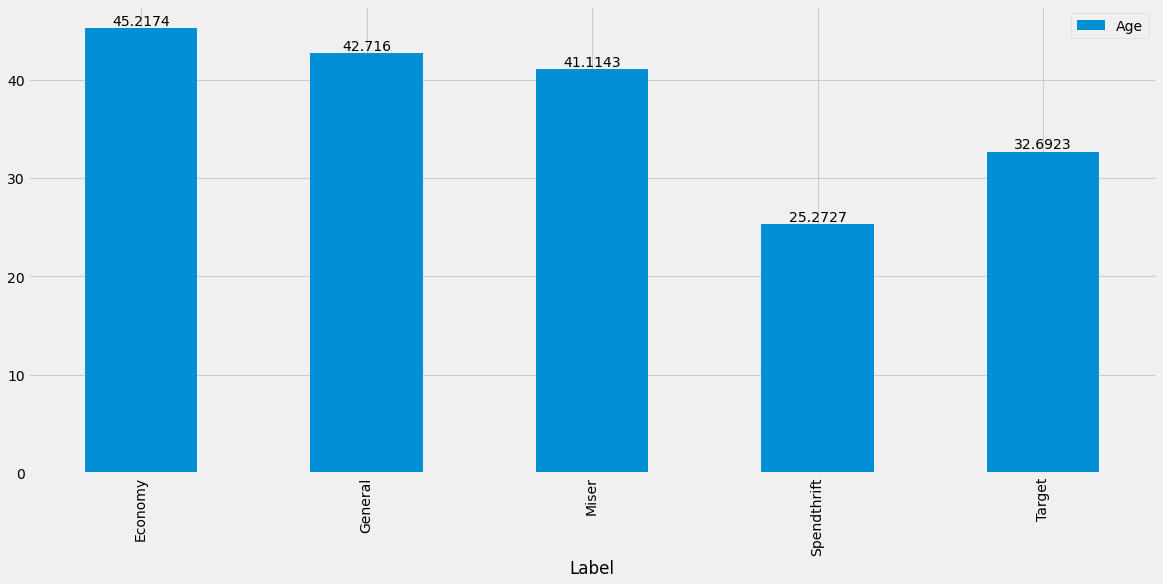

In [22]:
age_df = dataset[['Age','Label']]
age_df_mean = age_df.groupby('Label').mean().reset_index()

def plotMeanValue(dataframe, x_name, y_name):
    ax = dataframe.plot.bar(x=x_name, y=y_name)
    ax.bar_label(ax.containers[0])
plotMeanValue(age_df_mean, 'Label', 'Age')

Đánh giá về độ tuổi ta thấy:
* Nhóm tuổi trung bình trong khoảng từ 40+ (Trung niên): thường có xu hướng chi tiêu trung bình thấp, nhằm phục vu nhu cầu sử dụng thực tế.
* Nhóm tuổi trung bình 25 (Thanh niên): thường có xu hướng chi tiêu cho nhu cầu cá nhân và giải trí.
* Nhóm tuổi trung bình 32 (Người lập gia đình): Tập trung chi tiêu để phục vụ giai đình.

# 5. Tổng kết đánh giá và phương án cho các nhóm khách hàng

Từ các đánh giá trên ta có các phương án và cách tiếp thị riêng cho từng nhóm khách hàng:

**General**: 40.5% -
**Miser**: 17.5% - N
**Spendthrift**: 11%
**Economy**: -
**Target**: 19.5% - 

**Đối với nhóm khách hàng chung (General) chiếm 40.5%:**
> Họ thuộc kiểu khách hàng: *Người mua dễ chịu*, *Khách hàng trung thành*, *Mong đợi lợi ích thiết thực*
>> Là nhóm đối tượng đảm bảo nguồn doanh số ổn định cho công ti. Nhóm khách hàng này là đối tượng có thể gây ảnh hưởng đến các quyết định về thiết kế sản phẩm và cách thức bán hàng của doanh nghiệp. Đối với nhóm khách hàng này ta sẽ chạy các chương trình giới thiệu sản phẩm, giảm giá lần đầu cho họ đối với các sản phẩm mới để họ có thể biết và tiếp cận nhiều sản phẩm hơn, giúp nâng cao thêm doanh số cho công ti.

**Đối với nhóm khách hàng tiết kiệm (Economy) chiếm 11.5%**
> Họ thuộc kiểu khách hàng: *chỉ mua khi có nhu cầu*, *mong đợi lợi ích thiết thực* và đặc biệt là *chỉ mua khi có giảm giá* <br>
>> Đối với nhóm này ta sẽ tập trung phân phối cho họ các món hàng phân khúc giá rẻ, bình dân đặc biệt phân phát các coupon giảm giá cho họ như một mục đích để xả các hàng tồn kho, chuẩn bị hết đát của công ti, giúp cho công ti tránh lỗ.<br>

**Đối với nhóm kẹt xỉ (Miser) chiểm 7.5%:**
> Họ thuộc kiểu khách hàng: *người mua khó tính*, *mong đợi lợi ích thiết thực*, *chỉ mua khi có nhu cầu*,
>> Đây là nhóm khách hàng có tiền, có tuổi và cũng rất khó tính, chiếm số nhỏ trong chuỗi khách hàng. Họ tập trung đến lợi ích sản phẩm đem lại, đa phần những món hàng họ mua chính là những món quà có giá trị cao để gửi tặng người quen. Đối với các khách hàng này tuy là giống với nhóm khách hàng tiết kiệm nhưng lại trái ngược về phương án tiếp cận. Ở đây ta sẽ tiếp thị họ những sản phẩm có giá trị và chất lượng cao nhưng ít người mua, thi thoảng đưa ra những giảm giá sốc nhằm đánh vào tâm lý ít chi tiêu của họ để bán cho họ. Mục đích chính là để vẫn giữ chân loại khách hàng này trong chuỗi bán hàng của công ti và cũng vừa bán những món hàng đắt giá và cũng khó bán.

**Đối với nhóm khách hàng mục tiêu (Target) chiểm 19.5%**
> Họ thuộc kiểu khách hàng: *Mua theo xu hướng giải trí*, *Người mua dễ chịu*, *Khách hàng trung thành*
>> Nhóm khách hàng này rất dễ chịu, mua mọi món hàng để cho vui, đây là nhóm khách hàng không những đem lại doanh số ổn định cho công ti mà còn nâng tầm giá trị và đem lại những lời đồn và quảng cáo cho chuỗi bán hàng. Đối với nhóm khách hàng này ta 

1. Người mua theo xu hướng giải trí

Phân khúc khách hàng này có xu hướng yêu thích giải trí tại TTTM vì họ còn trẻ, độc thân. Do đó, nhà quản trị cần quan tâm hoặc bằng cách tự triển khai hoặc phối hợp cùng các đối tác khác làm phong phú thêm các dịch vụ.

1. Người mua mong đợi lợi ích thiết thực


2. Người mua dễ chịu

Phân loại theo nhu cầu mà ta đưa ra các phương hướng giảm giá phù hợp:

KHÁCH HÀNG TRUNG THÀNH:

Những khách hàng này thường chiếm hơn 20% tổng số khách hàng hiện tại của doanh nghiệp nhưng họ đóng góp đến hơn 50% doanh thu. Vì vậy, doanh nghiệp phải thường xuyên liên lạc với họ qua điện thoại, thư từ.. .Nhóm khách hàng này có thể và nên là đối tượng có thể gây ảnh hưởng đến các quyết định về thiết kế sản phẩm và cách thức bán hàng của doanh nghiệp.


NHỮNG KHÁCH HÀNG CHỈ MUA HÀNG KHI CÓ GIẢM GIÁ:

Nhóm khách hàng này mua hàng khá thường xuyên nhưng họ chỉ mua dựa trên mức độ giảm giá. Họ sẽ là những đối tượng khách hàng giúp doanh nghiệp giải phóng hàng tồn kho nhanh nhất và vì vậy là một nguồn bổ sung chính vào dòng tiền mặt của doanh nghiệp khi cần. Tuy nhiên, cũng chính nhóm khách hàng này có thể gây ra tổn thất cho doanh nghiệp vì họ thường có khuynh hướng trả hàng về.


NHỮNG KHÁCH HÀNG CHỈ MUA HÀNG KHI CÓ NHU CẦU:

Nhóm khách hàng này thường có ý định rõ ràng về việc mua một sản phẩm cụ thể. Khi bước vào cửa hàng, họ sẽ kiểm tra ngay liệu nhu cầu của họ có được đáp ứng không, nếu không, họ sẽ rời cửa hàng ngay. Họ mua hàng vì nhiều lý do khác nhau (nhân một dịp đặc biệt nào đó, để đáp ứng một nhu cầu cụ thể, vì giá cả đáp ứng đúng mong đợi của họ…).

Để khiến nhóm khách hàng này cảm thấy thỏa mãn không phải là một điều dễ dàng. Nhưng nếu làm được, doanh nghiệp sẽ có thể biến họ thành những khách hàng trung thành. Nên nhớ rằng những khách hàng mua hàng dựa trên nhu cầu cụ thể rất có khả năng chuyển sang một đối thủ cạnh tranh hay tìm đến Internet để mua hàng nếu nhu cầu của họ không được thỏa mãn ngay. Do đó, nhân viên bán hàng, nhất là những người giữ chức vụ cao, cần phải tạo ra sự tương tác cá nhân tích cực đối với họ. Dịch vụ tốt sẽ là yếu tố kéo họ đến cửa hàng.
